In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import collections
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from grid_method import *
from model import GHH
from architectures import *

In [4]:
def confidence_interval(arr):
    boot_means = []
    for _ in range(10000):
        bootsample = np.random.choice(arr, 100, replace = False)
        boot_mean = bootsample.mean()
        boot_means.append(boot_mean)
        
    ci = np.array([np.percentile(boot_means, 5), np.percentile(boot_means, 95)])
    return ci

In [4]:
def Lipschitz_1(ls, n_iter, window_size, nb, normalize, save_name1, save_name2):
    lips = torch.empty(len(ls), n_iter)
    nbs = torch.empty(len(ls), n_iter)
    
    for j in range(len(ls)):
        l = ls[j]
        stats1 = torch.empty(n_iter)
        stats2 = torch.empty(n_iter)
        for i in range(n_iter):
            d = torch.linspace(-1*window_size, window_size, nb)
            d = d.reshape(-1, 1)
            d.requires_grad_(True)
            output = arch_1(d,3,l,normalize)
            output.backward(torch.ones_like(output))
            grad = d.grad.reshape(-1)
            
            stats1[i] = grad.abs().max()
            stats2[i] = len(set(grad.numpy()))
            
        lips[j,:] = stats1
        nbs[j,:] = stats2
        print(f'{l}, finished.')
    lips_save = lips.numpy()
    np.save(save_name2, lips_save)
    nbs_save = nbs.numpy()
    np.save(save_name1, nbs_save)
    return nbs

In [5]:
d = torch.linspace(-1*40, 40, 8001)
d = d.reshape(-1, 1)
d.requires_grad_(True)
output = arch_1(d,3,3,normalize)
output.backward(torch.ones_like(output))
grad = d.grad.reshape(-1)
            
            

NameError: name 'normalize' is not defined

In [101]:
len(set(grad.numpy()))

10

# experiment

In [6]:
ls = np.arange(0,21,2)[1:]
ls_add = np.arange(20,51,5)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))
n_iter = 2000
window_size = 40
nb = 8001
normalize = True
save_name1 = 'W12/nbs_1_norm.npy'
save_name2 ='W12/lips_1_norm.npy'

lips = Lipschitz_1(ls, n_iter, window_size, nb, normalize, save_name1, save_name2)

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.
12, finished.
14, finished.
16, finished.
18, finished.
20, finished.
25, finished.
30, finished.
35, finished.
40, finished.
45, finished.
50, finished.


In [7]:
lips

tensor([[ 4.,  4.,  4.,  ...,  4.,  4.,  4.],
        [ 8.,  7.,  7.,  ...,  6.,  8.,  5.],
        [12.,  7.,  9.,  ..., 17., 14.,  6.],
        ...,
        [31., 33., 58.,  ..., 21., 31., 28.],
        [25., 36., 17.,  ..., 38., 35., 32.],
        [35., 26., 20.,  ..., 16., 20., 36.]])

In [119]:
lips.mean(axis = 1)

tensor([ 4.0000,  6.4500, 11.0500, 14.4500, 16.6000, 20.8000, 19.4000, 19.3000,
        22.9500, 28.6500, 27.4500, 22.7000, 28.4500, 25.5500, 25.0500, 22.1500,
        25.9000])

In [8]:
ls = np.arange(0,21,2)[1:]
ls_add = np.arange(20,51,5)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))

In [10]:
nbs_arch1 = np.load('W12/nbs_1_norm.npy')
lips_arch1 = np.load('W12/lips_1_norm.npy')

nbs_arch1_mean = nbs_arch1.mean(axis = 1)
lips_arch1_mean = lips_arch1.mean(axis = 1)

nbs_interval_arch1 = np.empty((2, nbs_arch1.shape[0]))
lips_interval_arch1 = np.empty((2, lips_arch1.shape[0]))

for i in range(nbs_arch1.shape[0]):
    nbs_interval_arch1[:,i] = confidence_interval(nbs_arch1[i,:])
for i in range(lips_arch1.shape[0]):
    lips_interval_arch1[:,i] = confidence_interval(lips_arch1[i,:])

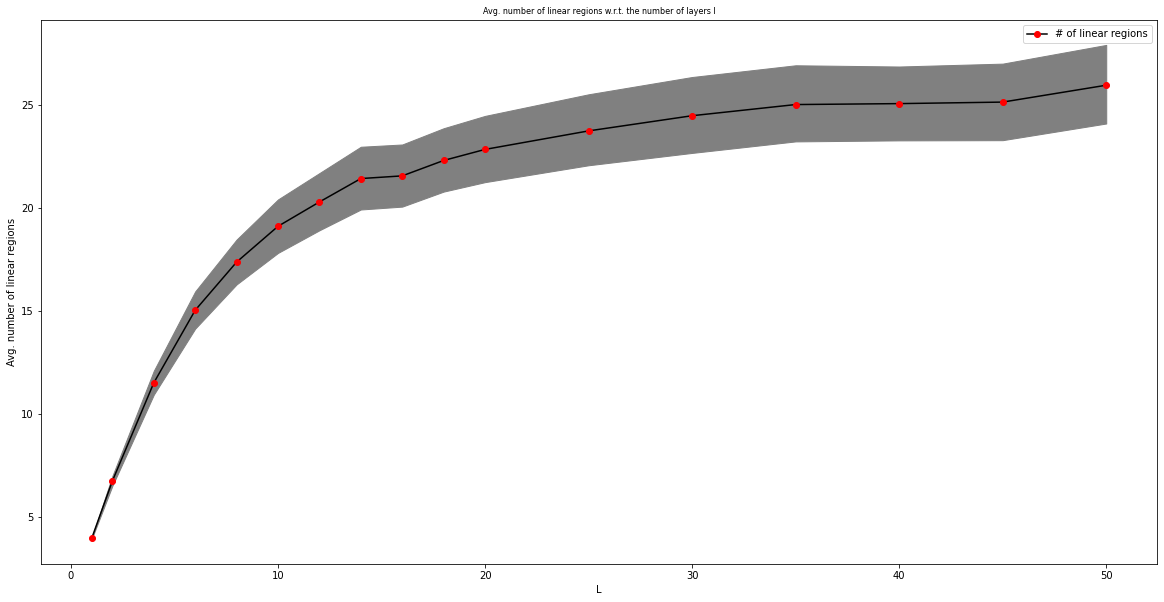

In [11]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,nbs_arch1_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, nbs_interval_arch1[0,:], nbs_interval_arch1[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l",fontsize=8)


plt.show()

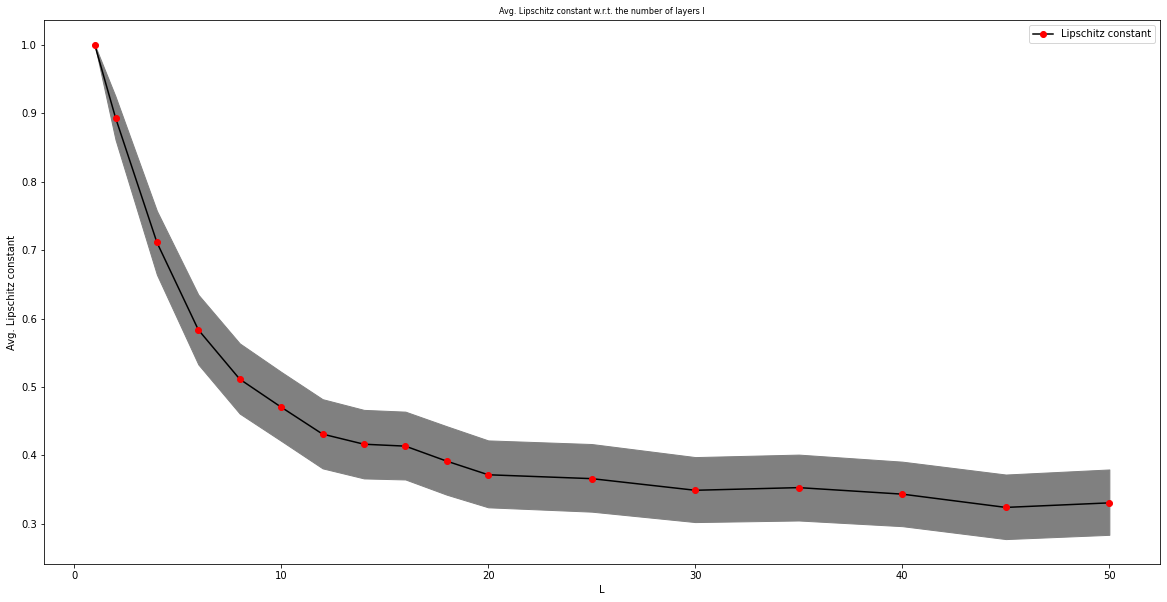

In [12]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,lips_arch1_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = 'Lipschitz constant')
plt.fill_between(ls, lips_interval_arch1[0,:], lips_interval_arch1[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. Lipschitz constant")
plt.title("Avg. Lipschitz constant w.r.t. the number of layers l",fontsize=8)


plt.show()

In [30]:
def Lipschitz_2(ls, n_iter, x_range, y_range, stepsize, normalize, save_name1, save_name2):
    lips = torch.empty(len(ls), n_iter)
    nbs = torch.empty(len(ls), n_iter)
    for j in range(len(ls)):
        l = ls[j]
        stats1 = torch.empty(n_iter)
        stats2 = torch.empty(n_iter)
        for i in range(n_iter):
            d, length = generate_grid(x_range, y_range, stepsize)
            d.requires_grad_(True)
            output = arch_2(d,3,l,normalize)
            output.backward(torch.ones_like(output))
            grad = d.grad
            # use the 2-norm of the gradient
            stats1[i] = grad.pow(2).sum(axis=1).sqrt().max()
            stats2[i] = len(set(grad[:,0].numpy()))
        lips[j,:] = stats1
        nbs[j,:] = stats2
        
        print(f'{l}, finished.')
    lips_save = lips.numpy()
    nbs_save = nbs.numpy()
    np.save(save_name1,nbs_save)
    np.save(save_name2,lips_save)
    return nbs

In [126]:
d, length = generate_grid(x_range, y_range, stepsize)
d.requires_grad_(True)
output = arch_2(d,3,10,normalize)
output.backward(torch.ones_like(output))
grad = d.grad
            # use the 2-norm of the gradient

len(set(grad[0,:].numpy()))

2

In [131]:
grad.shape

torch.Size([641601, 2])

# experiment

In [31]:
ls = np.arange(0,21,3)[1:]
ls_add = np.arange(20,51,10)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))
n_iter = 1000
x_range = [-20, 20]
y_range = [-20, 20]
stepsize = 0.05
normalize = True
save_name1 = 'W12/nbs_2_norm.npy'
save_name2 = 'W12/lips_2_norm.npy'

lips_2 = Lipschitz_2(ls, n_iter, x_range, y_range, stepsize, normalize, save_name1, save_name2)

1, finished.
3, finished.
6, finished.
9, finished.
12, finished.
15, finished.
18, finished.
30, finished.
40, finished.
50, finished.


In [134]:
lips_2

tensor([[ 12.,  17.,  16.,  13.,  16.],
        [ 54.,  67.,  42.,  36.,  40.],
        [ 62.,  34.,  50.,  52.,  63.],
        [ 90.,  46.,  80.,  88., 142.],
        [ 60.,  79.,  75.,  86.,  77.],
        [213., 106.,  45.,  86.,  64.],
        [ 84., 111., 116., 177.,  23.],
        [ 92.,  73., 103.,  55.,  82.],
        [ 78., 122.,  91.,  81., 185.],
        [ 99., 137.,  48., 220., 156.]])

In [32]:
ls = np.arange(0,21,3)[1:]
ls_add = np.arange(20,51,10)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))

In [34]:
nbs_arch2 = np.load('W12/nbs_2_norm.npy')
lips_arch2 = np.load('W12/lips_2_norm.npy')

nbs_arch2_mean = nbs_arch2.mean(axis = 1)
lips_arch2_mean = lips_arch2.mean(axis = 1)

nbs_interval_arch2 = np.empty((2, nbs_arch2.shape[0]))
lips_interval_arch2 = np.empty((2, lips_arch2.shape[0]))

for i in range(nbs_arch2.shape[0]):
    nbs_interval_arch2[:,i] = confidence_interval(nbs_arch2[i,:])
for i in range(lips_arch2.shape[0]):
    lips_interval_arch2[:,i] = confidence_interval(lips_arch2[i,:])

In [71]:
lips_arch2_mean

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float32)

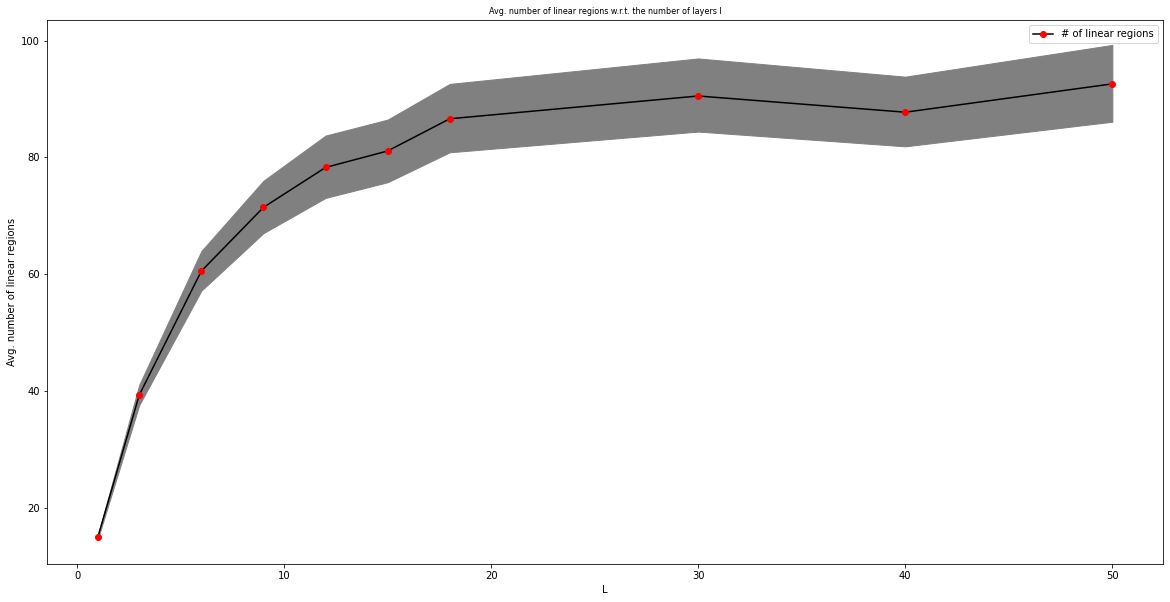

In [35]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,nbs_arch2_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, nbs_interval_arch2[0,:], nbs_interval_arch2[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l",fontsize=8)


plt.show()

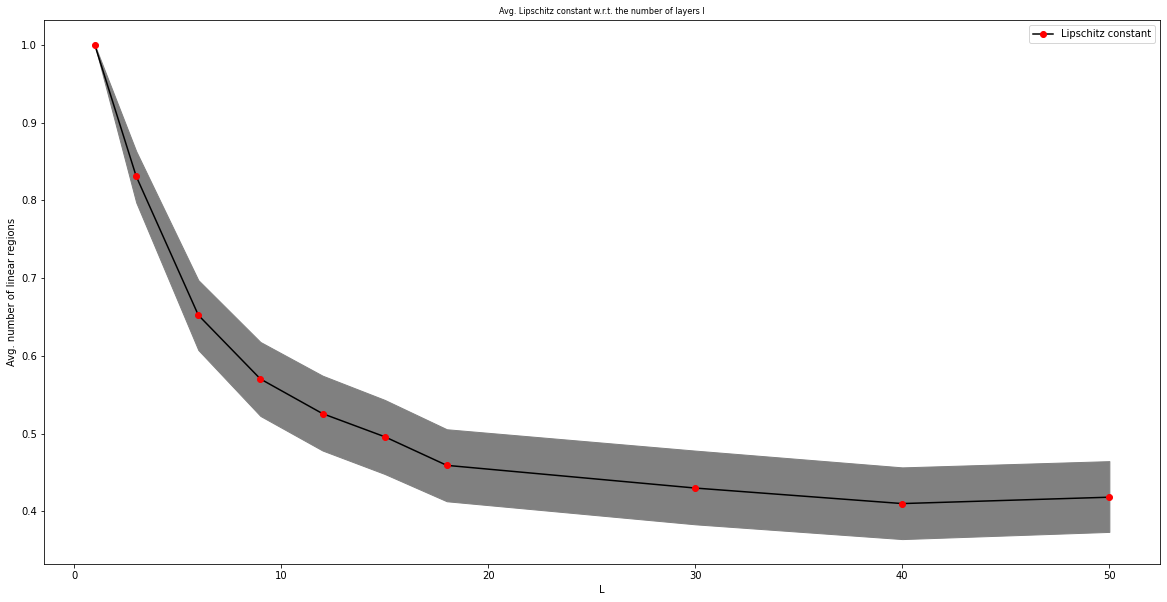

In [36]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,lips_arch2_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = 'Lipschitz constant')
plt.fill_between(ls, lips_interval_arch2[0,:], lips_interval_arch2[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. Lipschitz constant w.r.t. the number of layers l",fontsize=8)


plt.show()

In [18]:
def Lipschitz_3(ls, n_iter, window_size, nb, normalize, save_name1, save_name2):
    lips = torch.empty(len(ls), n_iter)
    nbs = torch.empty(len(ls), n_iter)
    
    for j in range(len(ls)):
        l = ls[j]
        stats1 = torch.empty(n_iter)
        stats2 = torch.empty(n_iter)
        
        for i in range(n_iter):
            d = torch.linspace(-1*window_size, window_size, nb)
            d = d.reshape(-1, 1)
            d.requires_grad_(True)
            output = arch_3(d,3,l, normalize)
            output.backward(torch.ones_like(output))
            grad = d.grad.reshape(-1)
            
            stats1[i] = grad.abs().max()
            stats2[i] = len(set(grad.numpy()))
        lips[j,:] = stats1
        nbs[j,:] = stats2
        print(f'{l}, finished.')
    lips_save = lips.numpy()
    np.save(save_name2, lips_save)
    nbs_save = nbs.numpy()
    np.save(save_name1, nbs_save)
    return lips

# experiment

In [22]:
ls = np.arange(0,21,2)[1:]
ls_add = np.arange(20,51,5)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))
n_iter = 2000
window_size = 40
nb = 8001
normalize = True
save_name1 = 'W12/nbs_3_norm.npy'
save_name2 = 'W12/lips_3_norm.npy'

lips_3 = Lipschitz_3(ls, n_iter, window_size, nb, normalize, save_name1, save_name2)

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.
12, finished.
14, finished.
16, finished.
18, finished.
20, finished.
25, finished.
30, finished.
35, finished.
40, finished.
45, finished.
50, finished.


In [6]:
nbs_arch3 = np.load('W12/nbs_3_norm.npy')
lips_arch3 = np.load('W12/lips_3_norm.npy')

nbs_arch3_mean = nbs_arch3.mean(axis = 1)
lips_arch3_mean = lips_arch3.mean(axis = 1)

nbs_interval_arch3 = np.empty((2, nbs_arch3.shape[0]))
lips_interval_arch3 = np.empty((2, lips_arch3.shape[0]))
for i in range(nbs_arch3.shape[0]):
    nbs_interval_arch3[:,i] = confidence_interval(nbs_arch3[i,:])
for i in range(lips_arch3.shape[0]):
    lips_interval_arch3[:,i] = confidence_interval(lips_arch3[i,:])

In [8]:
nbs_arch3_mean

array([12.2355, 12.2735, 29.6645, 44.2   , 55.423 , 64.0315, 70.5735,
       74.971 , 79.813 , 82.569 , 85.882 , 90.781 , 92.967 , 93.83  ,
       95.924 , 97.7555, 97.854 ], dtype=float32)

In [9]:
ls = np.arange(0,21,2)[1:]
ls_add = np.arange(20,51,5)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))

In [11]:
ls

array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50])

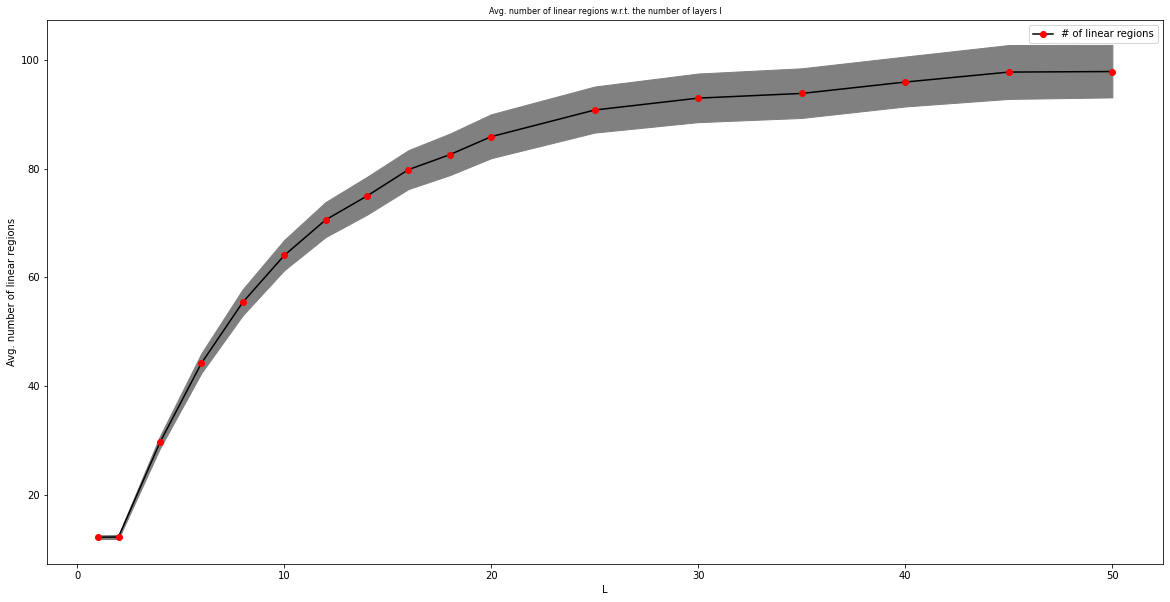

In [10]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,nbs_arch3_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, nbs_interval_arch3[0,:], nbs_interval_arch3[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l",fontsize=8)


plt.show()

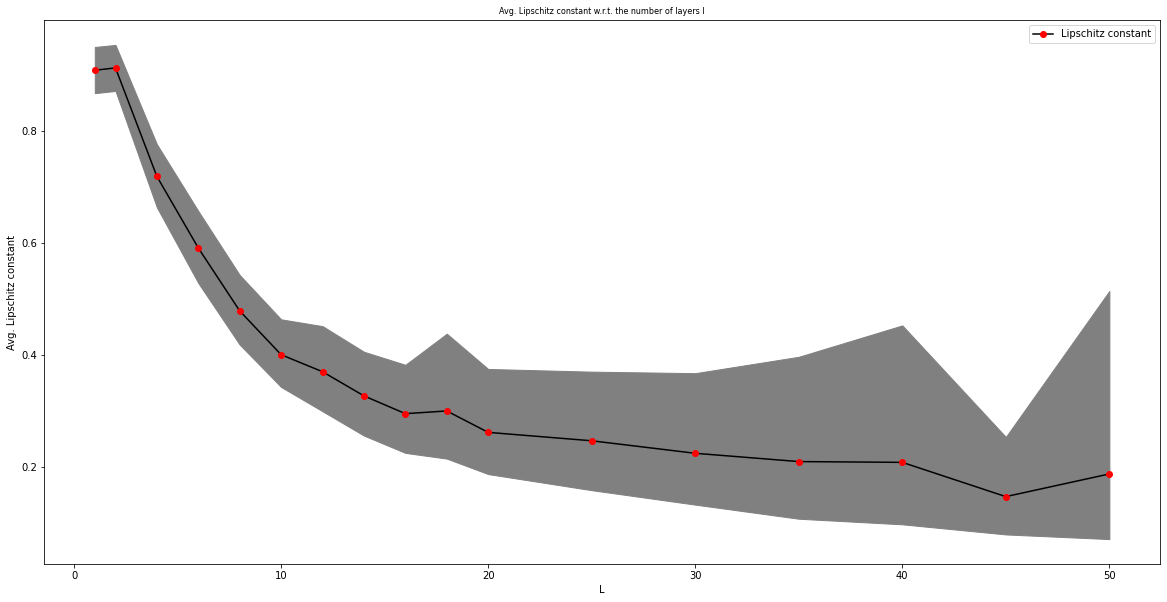

In [27]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,lips_arch3_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = 'Lipschitz constant')
plt.fill_between(ls, lips_interval_arch3[0,:], lips_interval_arch3[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. Lipschitz constant")
plt.title("Avg. Lipschitz constant w.r.t. the number of layers l",fontsize=8)


plt.show()

In [11]:
def Lipschitz_4(ls, n_iter, x_range, y_range, stepsize, normalize, save_name1, save_name2):
    lips = torch.empty(len(ls), n_iter)
    nbs = torch.empty(len(ls), n_iter)
    for j in range(len(ls)):
        l = ls[j]
        stats1 = torch.empty(n_iter)
        stats2 = torch.empty(n_iter)
        for i in range(n_iter):
            d, length = generate_grid(x_range, y_range, stepsize)
            d.requires_grad_(True)
            output = arch_4(d,3,l,normalize)
            output.backward(torch.ones_like(output))
            grad = d.grad
            # use the 2-norm of the gradient
            stats1[i] = grad.pow(2).sum(axis=1).sqrt().max()
            stats2[i] = len(set(grad[:,0].numpy()))
        lips[j,:] = stats1
        nbs[j,:] = stats2
        
        print(f'{l}, finished.')
    lips_save = lips.numpy()
    nbs_save = nbs.numpy()
    np.save(save_name1,nbs_save)
    np.save(save_name2,lips_save)
    return lips

In [12]:
ls = np.arange(0,21,3)[1:]
ls_add = np.arange(20,51,10)[1:]
ls = np.concatenate((ls, ls_add))
ls = np.concatenate((np.array([1]), ls))
n_iter = 1000
x_range = [-20, 20]
y_range = [-20, 20]
stepsize = 0.05
normalize = True
save_name1 = 'W12/nbs_4_norm.npy'
save_name2 = 'W12/lips_4_norm.npy'

lips_4 = Lipschitz_4(ls, n_iter, x_range, y_range, stepsize, normalize, save_name1, save_name2)

1, finished.
3, finished.
6, finished.
9, finished.
12, finished.
15, finished.
18, finished.
30, finished.
40, finished.
50, finished.


In [10]:
lips = np.load('W12/lips_4_norm.npy')
lips.mean(axis = 1)

array([0.9089706 , 1.2707891 , 0.9563916 , 0.6199351 , 0.5674575 ,
       0.24088116, 0.24230237, 0.14173451, 0.06208989, 0.9900067 ],
      dtype=float32)

In [ ]:
nbs_arch2 = np.load('W12/nbs_2_norm.npy')
lips_arch2 = np.load('W12/lips_2_norm.npy')

nbs_arch2_mean = nbs_arch2.mean(axis = 1)
lips_arch2_mean = lips_arch2.mean(axis = 1)

nbs_interval_arch2 = np.empty((2, nbs_arch2.shape[0]))
lips_interval_arch2 = np.empty((2, lips_arch2.shape[0]))

for i in range(nbs_arch2.shape[0]):
    nbs_interval_arch2[:,i] = confidence_interval(nbs_arch2[i,:])
for i in range(lips_arch2.shape[0]):
    lips_interval_arch2[:,i] = confidence_interval(lips_arch2[i,:])

In [ ]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,nbs_arch2_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, nbs_interval_arch2[0,:], nbs_interval_arch2[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l",fontsize=8)


plt.show()

In [ ]:
fig = plt.figure(figsize=(20,10))


plt.plot(ls,lips_arch2_mean,'k-',marker = 'o',mfc = 'r', mec = 'r', label = 'Lipschitz constant')
plt.fill_between(ls, lips_interval_arch2[0,:], lips_interval_arch2[1,:], color='gray')
plt.legend()

plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. Lipschitz constant w.r.t. the number of layers l",fontsize=8)


plt.show()